# Трек «Аналитика данных»

Кейс 4
<br>
Задание от ООО «АЛРОСА ИТ»

#### Разработка алгоритма, который позволяет сортировать алмазы для формирования боксов на продажу

Цель: Разработка алгоритма, который позволяет сортировать алмазы для формирования боксов на продажу

Описание: есть 1000 алмазов разных по размеру, форме, цвету, весу, флуоресценции, стоимости. Они все формируются в боксы (по около 100 единиц) на продажу клиентам. 
Необходимо создать алгоритм, который позволит сформировать n-ное количество боксов с алмазами так, чтобы выручка от продажи 1000 алмазов была максимальной.

#### Характеристики камней:
    – Цвет: синий, красный, зеленый, желтый
    – Форма: звезда, круг, квадрат, треугольник
    – Размер: большой, средний, маленький
    – Вес: большой, средний, маленький
    – Флуоресценции: светятся или нет в темноте
    – Стоимость: камни имеют разную стоимость за грамм.

Данные представлены для удобства в Excel таблице ([ссылка](https://docs.google.com/spreadsheets/d/1csZxbGm05i_EhF8iBnhsaTB-7JLXii5C/edit?usp=sharing&ouid=109147775829498063017&rtpof=true&sd=true)) 

#### Алгоритм должен удовлетворять следующим требованиям: 
1. Чем меньше расхождение любой из характеристик (форма, цвет и т.д) в боксах, тем лучше.
2. Алгоритм должен работать максимально быстро.

<b>Кейсодатель:</b><br>
ФИО: Карамзина Марина Анатольевна<br>
Должность и место работы: Руководитель Региональный центр обслуживания г. Якутск, ООО «АЛРОСА ИТ»<br>
Контакты: 8924 361-35-14


## Содержание исследования
_____

#### Подготовка:
* <a href="#step_1">1. Изучение файлов с данными, получение общей информации, загрузка библиотек.</a>

#### Исследовательский анализ данных:
* <a href="#step_21">2.1 Сортировка признаков по стоимости,  средние значения и стандартные отклонения.</a>
* <a href="#step_24">2.2 Матрица корелляций.</a>

#### Кластеризация:
* <a href="#step_4">3. Кластеризация камней.</a>

<a id='step_1'></a>
## 1. Изучение файлов с данными, получение общей информации, загрузка библиотек:

In [1]:
import time
start_time = time.time()

import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np

import xlrd

from k_means_constrained import KMeansConstrained

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

#Перманентно поменял настройки вывода графиков
from matplotlib import pylab
from pylab import *
pylab.rcParams['figure.figsize'] = (18.0, 6.0)
plt.rcParams.update({'font.size': 13})
sns.set(rc={'figure.figsize':(16,9)})

#Скрыл вывод предупреждений.
import warnings
warnings.filterwarnings('ignore') #чтобы вернуть: (action='once')

# Глобально снял ограничение на кол-во отображаемых результатов для каждой ячейки ввода кода.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Включил возможность форматировать стили текста с помощью метода printmd()
from IPython.display import Markdown, display, HTML
def printmd(string):
    display(Markdown(string))
    
# Снял ограничение на вывод кол-ва столбцов и ширины колонки.
pd.set_option('display.max_columns', None)
try:
    pd.set_option('display.max_colwidth', None)
except:
    pd.set_option('display.max_colwidth', -1)

# Установил формат вывода в таблице на 2 знака после запятой.
pd.options.display.float_format = '{:,.2f}'.format
    
# Добавил функцию вывода таблиц в одну строку, для экономии пространства и улучшения восприятия информации.
def display_side_by_side(dfs:list, captions:list):
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

In [2]:
df = pd.read_excel('case.xlsm', sheet_name='Таблица')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Номер          1000 non-null   int64 
 1   Форма          1000 non-null   object
 2   Цвет           1000 non-null   object
 3   Размер         1000 non-null   object
 4   Флуоресценция  1000 non-null   object
 5   Вес            1000 non-null   int64 
 6   Стоимость      1000 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 54.8+ KB


In [3]:
df = df.rename(columns = {'Номер':'id','Форма':'form','Цвет':'color','form':'','Размер':'size','Флуоресценция':'light','Вес':'weight','Стоимость': 'cost'})
del df['id']
df.head(10)

,form,color,size,light,weight,cost
0,Треугольник,Зелёный,Средний,Не светится,276,4
1,Треугольник,Красный,Большой,Не светится,814,8
2,Квадрат,Красный,Средний,Не светится,416,4
3,Квадрат,Жёлтый,Большой,Не светится,564,7
4,Квадрат,Красный,Средний,Не светится,491,4
5,Звезда,Зелёный,Малый,Не светится,14,1
6,Круг,Зелёный,Большой,Не светится,606,5
7,Треугольник,Cиний,Малый,Светится,94,2
8,Звезда,Жёлтый,Малый,Не светится,61,1
9,Круг,Зелёный,Малый,Светится,209,1


In [4]:
### Отсортировали значения по средней стоимости от меньшего к большему
def declare_cost(col):
    print(df.groupby(col)['cost'].mean().sort_values())
        
declare_cost('form')
declare_cost('color')
declare_cost('size')
declare_cost('light')

form
Треугольник   3.41
Квадрат       3.42
Звезда        3.70
Круг          4.20
Name: cost, dtype: float64
color
Красный   3.50
Cиний     3.65
Жёлтый    3.69
Зелёный   3.78
Name: cost, dtype: float64
size
Малый     2.02
Средний   3.98
Большой   6.99
Name: cost, dtype: float64
light
Не светится   3.59
Светится      3.81
Name: cost, dtype: float64


Самый дорогой - круглый, зеленый, большой, светящийся камень<br>
Самый дешевый - треугольный, красный, малый, не светящийся камень

In [5]:
def count_of(col):
    hist = df.groupby(col).agg({col:'count','cost':'sum'}).rename(columns={col: 'count'})
    return hist


display_side_by_side([count_of('form'),count_of('color'),count_of('size'),count_of('light')],['Форма','Цвет','Размер','Флуоресценция'])

,count,cost
form,,
Звезда,490,1815
Квадрат,240,822
Круг,120,504
Треугольник,150,512
,count,cost
color,,
Cиний,110,402
Жёлтый,510,1883
Зелёный,130,492


In [6]:
'''Самая частая форма'''
count_of('form')['count'].sort_values().tail(1)
'''Самый частый цвет'''
count_of('color')['count'].sort_values().tail(1)
'''Самый частый размер'''
count_of('size')['count'].sort_values().tail(1)
'''Самая частая флуоресценция'''
count_of('light')['count'].sort_values().tail(1)

'Самая частая форма'

form
Звезда    490
Name: count, dtype: int64

'Самый частый цвет'

color
Жёлтый    510
Name: count, dtype: int64

'Самый частый размер'

size
Средний    580
Name: count, dtype: int64

'Самая частая флуоресценция'

light
Не светится    700
Name: count, dtype: int64

<a id='step_2'></a>
## 2. Исследовательский анализ данных:

<a id='step_21'></a>
### 2.1 Сортировка признаков по стоимости,  средние значения и стандартные отклонения:

In [7]:
main_dict = {}

def text_to_int(x):
    return d.get(x)

'''Заменил названия на числовые значения по словарю:'''
for col_name in df.select_dtypes(include=['object']).columns.tolist():
    d = {}
    n = 0
    for col_dict in df.groupby(col_name)['cost'].mean().sort_values().index:
        d.update({col_dict:n})
        n +=1
    main_dict.update({col_name:d})
    df[col_name] = df[col_name].apply(lambda x: text_to_int(x))
    
main_dict
df.head(10)

'Заменил названия на числовые значения по словарю:'

{'form': {'Треугольник': 0, 'Квадрат': 1, 'Звезда': 2, 'Круг': 3},
 'color': {'Красный': 0, 'Cиний': 1, 'Жёлтый': 2, 'Зелёный': 3},
 'size': {'Малый': 0, 'Средний': 1, 'Большой': 2},
 'light': {'Не светится': 0, 'Светится': 1}}

,form,color,size,light,weight,cost
0,0,3,1,0,276,4
1,0,0,2,0,814,8
2,1,0,1,0,416,4
3,1,2,2,0,564,7
4,1,0,1,0,491,4
5,2,3,0,0,14,1
6,3,3,2,0,606,5
7,0,1,0,1,94,2
8,2,2,0,0,61,1
9,3,3,0,1,209,1


In [25]:
df.describe()

,form,color,size,light,weight,cost,value
count,"1,000.00","1,000.00","1,000.00","1,000.00","1,000.00","1,000.00","1,000.00"
mean,1.58,1.52,0.78,0.30,333.69,3.65,2.06
std,0.89,1.01,0.61,0.46,198.09,1.68,5.28
min,0.00,0.00,0.00,0.00,2.00,1.00,0.40
25%,1.00,0.75,0.00,0.00,197.00,3.00,0.85
50%,2.00,2.00,1.00,0.00,333.00,3.00,1.12
75%,2.00,2.00,1.00,1.00,439.00,5.00,1.49
max,3.00,3.00,2.00,1.00,992.00,9.00,100.00


<AxesSubplot:>

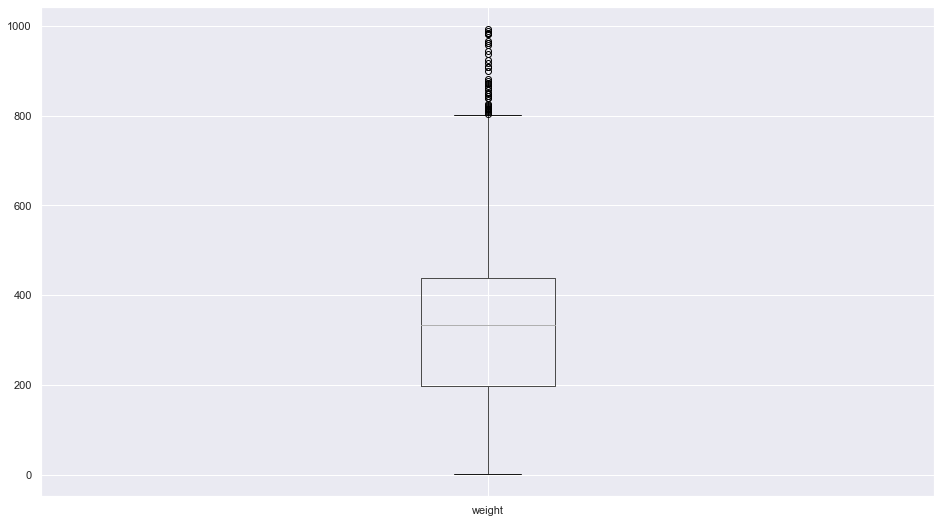

In [9]:
df['weight'].to_frame().boxplot()

<AxesSubplot:>

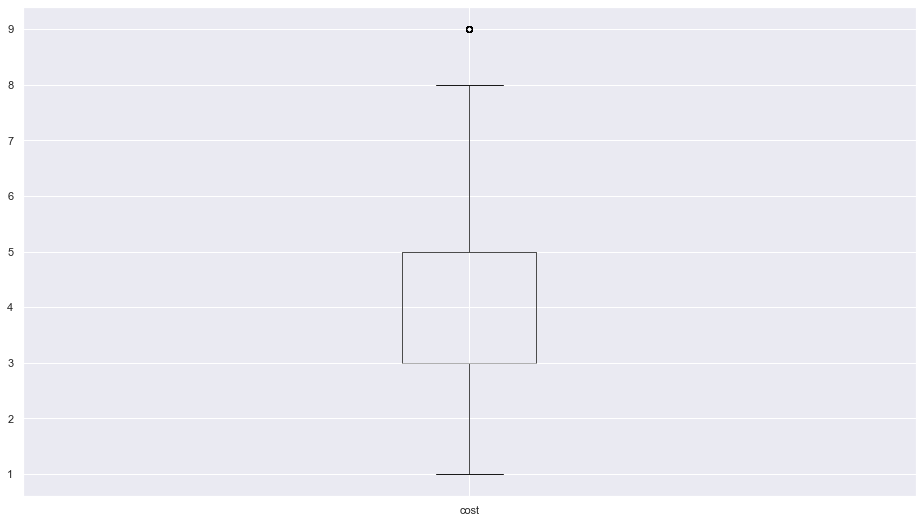

In [10]:
df['cost'].to_frame().boxplot()

Выводы:
* Средняя стоимость камней 3.65
* Средний вес 333.69
* В основном вес камней от 197 до 333. Камни весом больше 800, считаются редкостью
* Самый маленький камень весом 2, самый большой - 992.

<a id='step_24'></a>
### 2.2 Матрица корелляций:

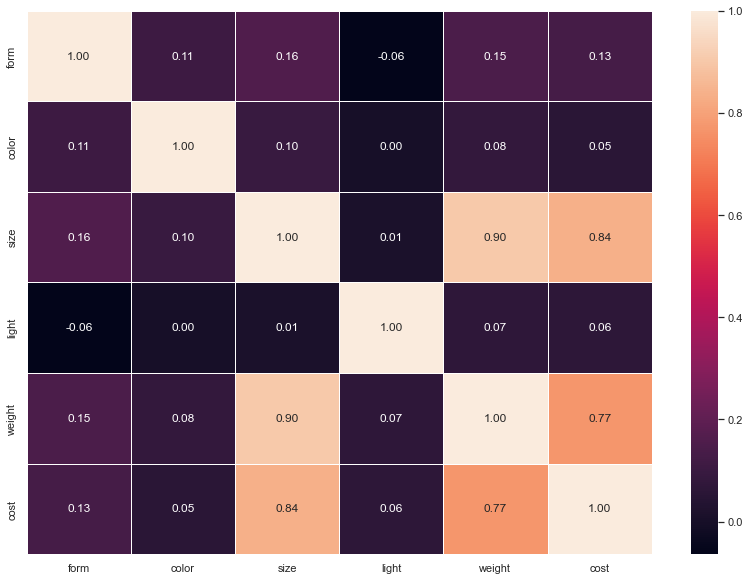

In [11]:
cm = df.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot = True, fmt = '0.2f', linewidths=.5)
plt.show();

In [41]:
df['value'] = (df['cost'] / df['weight']) * 10000

'''Камни по стоимости'''
df.sort_values(by="value",ascending=False).head(10)

,form,color,size,light,weight,cost,value
623,2,2,0,0,2,2,"10,000.00"
573,1,0,0,0,3,2,"6,666.67"
206,3,2,0,1,5,3,"6,000.00"
352,0,0,0,0,6,2,"3,333.33"
443,2,2,0,0,6,2,"3,333.33"
151,3,2,0,0,3,1,"3,333.33"
690,1,2,0,0,10,3,"3,000.00"
467,2,0,0,1,11,3,"2,727.27"
372,2,0,0,0,11,3,"2,727.27"
583,2,0,0,1,13,3,"2,307.69"


### Вывод

На стоимость в первую очередь влияет размер/вес. В меньше степени форма, цвет и флуоресценция. По соотношению вес к стоимости есть супер дорогие камни.

<a id='step_4'></a>
## 3. Кластеризация камней:

In [39]:
# Провел стандартизацию всех параметров
df_sс = df.drop(['cost','weight'], axis=1)
df_columns_list = df_sс.columns

# Преобразовал набор данных
df_sс = StandardScaler().fit_transform(df_sс)
df_sс = pd.DataFrame(df_sс, columns = df_columns_list).astype('float64')

'''Веса параметров'''
df_sс

# Сформировал таблицу связок
linked = linkage(df_sс, method = 'ward')

km = KMeansConstrained(init='k-means++', n_clusters = 10, size_min=100,size_max=100,random_state=0)
labels = km.fit_predict(df_sс)
df_cl = df[df.columns]
df_cl['cluster'] = labels

'''Количество камней в каждом кластере'''
df_cl.cluster.value_counts()

'''Средние значения по кластерам'''
df_cl.groupby('cluster').mean().T

'Веса параметров'

,form,color,size,light,value
0,-1.78,1.47,0.36,-0.65,-0.12
1,-1.78,-1.51,2.00,-0.65,-0.20
2,-0.66,-1.51,0.36,-0.65,-0.21
3,-0.66,0.48,2.00,-0.65,-0.15
4,-0.66,-1.51,0.36,-0.65,-0.24
...,...,...,...,...,...
995,0.47,0.48,0.36,-0.65,-0.23
996,0.47,0.48,0.36,-0.65,-0.20
997,0.47,0.48,0.36,-0.65,-0.25
998,0.47,0.48,0.36,-0.65,-0.20


'Количество камней в каждом кластере'

0    100
1    100
2    100
3    100
4    100
5    100
6    100
7    100
8    100
9    100
Name: cluster, dtype: int64

'Средние значения по кластерам'

cluster,0,1,2,3,4,5,6,7,8,9
form,2.00,1.14,1.91,0.87,1.87,0.53,2.00,2.60,0.67,2.21
color,2.00,1.36,1.72,0.29,0.18,1.40,2.00,1.84,2.26,2.15
size,1.00,0.00,0.00,0.33,1.09,1.42,1.00,1.17,0.63,1.16
light,0.00,1.00,0.11,0.00,0.00,0.89,0.00,1.00,0.00,0.00
weight,428.25,128.28,93.91,211.77,414.26,535.91,369.89,473.42,281.97,399.27
cost,3.39,2.03,2.17,2.64,4.39,5.32,3.96,4.58,3.18,4.87
value,79.53,249.67,883.80,146.44,109.83,104.68,107.48,109.10,135.87,132.42


In [14]:
df_final = df_cl

reverse_dict = {}

for item in main_dict:
    temp_dict = {v: k for k, v in main_dict[item].items()}
    reverse_dict.update({item:temp_dict})
    
reverse_dict

for col_name in reverse_dict.keys():
    df_final[col_name] = df_final[col_name].map(reverse_dict[col_name])

df_final.head(10)

{'form': {0: 'Треугольник', 1: 'Квадрат', 2: 'Звезда', 3: 'Круг'},
 'color': {0: 'Красный', 1: 'Cиний', 2: 'Жёлтый', 3: 'Зелёный'},
 'size': {0: 'Малый', 1: 'Средний', 2: 'Большой'},
 'light': {0: 'Не светится', 1: 'Светится'}}

,form,color,size,light,weight,cost,cluster
0,Треугольник,Зелёный,Средний,Не светится,276,4,3
1,Треугольник,Красный,Большой,Не светится,814,8,3
2,Квадрат,Красный,Средний,Не светится,416,4,6
3,Квадрат,Жёлтый,Большой,Не светится,564,7,3
4,Квадрат,Красный,Средний,Не светится,491,4,6
5,Звезда,Зелёный,Малый,Не светится,14,1,4
6,Круг,Зелёный,Большой,Не светится,606,5,5
7,Треугольник,Cиний,Малый,Светится,94,2,9
8,Звезда,Жёлтый,Малый,Не светится,61,1,4
9,Круг,Зелёный,Малый,Светится,209,1,9


### Результат

In [15]:
def data_mart(col_name):
    grouped = df_final.groupby(['cluster',col_name]).agg({col_name: 'count','weight':'sum','cost':'sum'})\
              .rename(columns={col_name:'count'})
    grouped_perc = df_final.groupby(['cluster',col_name]).agg({col_name: 'count'}).rename(columns={col_name:'percent'})\
                   .groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
    grouped['percent'] = grouped_perc['percent']
#
    return grouped
display_side_by_side([data_mart('form'),data_mart('color'),data_mart('size'),data_mart('light')],\
                     ['Форма','Цвет','Размер','Флуоресценция'])

## Подготовка JSON-массива:

In [16]:
df_final.set_index(['cluster']).sort_values(by='cluster')

,form,color,size,light,weight,cost
cluster,,,,,,
0,Звезда,Жёлтый,Средний,Не светится,257,4
0,Звезда,Жёлтый,Средний,Не светится,263,3
0,Звезда,Жёлтый,Средний,Не светится,353,5
0,Звезда,Жёлтый,Средний,Не светится,382,4
0,Звезда,Жёлтый,Средний,Не светится,430,4
...,...,...,...,...,...,...
9,Квадрат,Зелёный,Малый,Светится,96,1
9,Звезда,Зелёный,Малый,Светится,177,3
9,Треугольник,Зелёный,Средний,Светится,278,3


In [17]:
data = {"clusters":{}};
data['clusters']['id'] = {}
data

{'clusters': {'id': {}}}

In [18]:
data_mart('form').head(1)

,,count,weight,cost,percent
cluster,form,,,,
0,Звезда,100,37118,403,100.00


In [19]:
final_parameters = pd.DataFrame(columns=['cluster','items'])

for parameter in reverse_dict:
    temp = (data_mart(parameter).reset_index().groupby(['cluster',parameter])
            .apply(lambda x: x[[parameter,'count','weight','cost','percent']].to_dict('records'))
            .reset_index()
            .rename(columns={0:'items'}))
#     temp['']
    final_parameters = final_parameters.append(temp)
    
with open('parameters.json', 'w', encoding='utf-8') as file:
    final_parameters.sort_values(by='cluster').to_json(file, orient='records', force_ascii=False)

In [20]:
final_parameters

,cluster,items,form,color,size,light
0,0,"[{'form': 'Звезда', 'count': 100, 'weight': 37118, 'cost': 403, 'percent': 100.0}]",Звезда,NaN,NaN,NaN
1,1,"[{'form': 'Звезда', 'count': 29, 'weight': 4063, 'cost': 61, 'percent': 29.0}]",Звезда,NaN,NaN,NaN
2,1,"[{'form': 'Квадрат', 'count': 35, 'weight': 4679, 'cost': 69, 'percent': 35.0}]",Квадрат,NaN,NaN,NaN
3,1,"[{'form': 'Круг', 'count': 7, 'weight': 961, 'cost': 14, 'percent': 7.0}]",Круг,NaN,NaN,NaN
4,1,"[{'form': 'Треугольник', 'count': 29, 'weight': 6170, 'cost': 75, 'percent': 29.0}]",Треугольник,NaN,NaN,NaN
...,...,...,...,...,...,...
7,5,"[{'light': 'Светится', 'count': 89, 'weight': 53779, 'cost': 517, 'percent': 89.0}]",NaN,NaN,NaN,Светится
8,6,"[{'light': 'Не светится', 'count': 100, 'weight': 39865, 'cost': 439, 'percent': 100.0}]",NaN,NaN,NaN,Не светится
9,7,"[{'light': 'Не светится', 'count': 100, 'weight': 37692, 'cost': 389, 'percent': 100.0}]",NaN,NaN,NaN,Не светится
10,8,"[{'light': 'Не светится', 'count': 100, 'weight': 40573, 'cost': 397, 'percent': 100.0}]",NaN,NaN,NaN,Не светится


In [21]:
df_final

,form,color,size,light,weight,cost,cluster
0,Треугольник,Зелёный,Средний,Не светится,276,4,3
1,Треугольник,Красный,Большой,Не светится,814,8,3
2,Квадрат,Красный,Средний,Не светится,416,4,6
3,Квадрат,Жёлтый,Большой,Не светится,564,7,3
4,Квадрат,Красный,Средний,Не светится,491,4,6
...,...,...,...,...,...,...,...
995,Звезда,Жёлтый,Средний,Не светится,477,4,8
996,Звезда,Жёлтый,Средний,Не светится,408,4,8
997,Звезда,Жёлтый,Средний,Не светится,397,3,8
998,Звезда,Жёлтый,Средний,Не светится,498,5,8


In [22]:
# temp_mart.pivot_table(values=['weight','cost','percent','count'],index=['cluster','parameter','form'])

In [42]:
# final_par['par'] = final_par.apply(lambda x: x[['parameter','color','size','light']].to_dict('records'))

In [43]:
final_par = 0
for parameter in reverse_dict:
    temp_mart = data_mart(parameter).reset_index().sort_values(by='cluster')
    temp_mart['parameter'] = parameter
    try:
        final_par = final_par.append(temp_mart)
    except:
        final_par = temp_mart

final_par

,cluster,form,count,weight,cost,percent,parameter,color,size,light
0,0,Звезда,100,37118,403,100.00,form,NaN,NaN,NaN
1,1,Звезда,29,4063,61,29.00,form,NaN,NaN,NaN
2,1,Квадрат,35,4679,69,35.00,form,NaN,NaN,NaN
3,1,Круг,7,961,14,7.00,form,NaN,NaN,NaN
4,1,Треугольник,29,6170,75,29.00,form,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
7,5,NaN,89,53779,517,89.00,light,NaN,NaN,Светится
8,6,NaN,100,39865,439,100.00,light,NaN,NaN,Не светится
9,7,NaN,100,37692,389,100.00,light,NaN,NaN,Не светится
10,8,NaN,100,40573,397,100.00,light,NaN,NaN,Не светится


In [45]:
d = (data_mart('form').reset_index().sort_values(by='cluster').groupby(['cluster'])
            .apply(lambda x: x[['form','percent']].to_dict('records'))
            .reset_index()
            .rename(columns={0:'items'}))
d

,cluster,items
0,0,"[{'form': 'Звезда', 'percent': 100.0}]"
1,1,"[{'form': 'Звезда', 'percent': 29.0}, {'form': 'Квадрат', 'percent': 35.0}, {'form': 'Круг', 'percent': 7.0}, {'form': 'Треугольник', 'percent': 29.0}]"
2,2,"[{'form': 'Звезда', 'percent': 32.0}, {'form': 'Квадрат', 'percent': 30.0}, {'form': 'Круг', 'percent': 16.0}, {'form': 'Треугольник', 'percent': 22.0}]"
3,3,"[{'form': 'Звезда', 'percent': 1.0}, {'form': 'Квадрат', 'percent': 63.0}, {'form': 'Треугольник', 'percent': 36.0}]"
4,4,"[{'form': 'Треугольник', 'percent': 25.0}, {'form': 'Круг', 'percent': 5.0}, {'form': 'Звезда', 'percent': 42.0}, {'form': 'Квадрат', 'percent': 28.0}]"
5,5,"[{'form': 'Звезда', 'percent': 34.0}, {'form': 'Квадрат', 'percent': 15.0}, {'form': 'Круг', 'percent': 51.0}]"
6,6,"[{'form': 'Звезда', 'percent': 54.0}, {'form': 'Квадрат', 'percent': 37.0}, {'form': 'Круг', 'percent': 9.0}]"
7,7,"[{'form': 'Звезда', 'percent': 100.0}]"
8,8,"[{'form': 'Звезда', 'percent': 79.0}, {'form': 'Круг', 'percent': 21.0}]"
9,9,"[{'form': 'Круг', 'percent': 11.0}, {'form': 'Звезда', 'percent': 19.0}, {'form': 'Квадрат', 'percent': 32.0}, {'form': 'Треугольник', 'percent': 38.0}]"


In [46]:
j = (df_final.groupby(['cluster'])
       .apply(lambda x: x[['form','color','size','light','weight','cost']].to_dict('records'))
       .reset_index()
       .rename(columns={0:'items'}))
with open('rs.json', 'w', encoding='utf-8') as file:
    j.to_json(file, orient='records', force_ascii=False)

In [47]:
j.to_json(orient='records', force_ascii=False)

'[{"cluster":0,"items":[{"form":"Звезда","color":"Жёлтый","size":"Средний","light":"Не светится","weight":257,"cost":4},{"form":"Звезда","color":"Жёлтый","size":"Средний","light":"Не светится","weight":381,"cost":5},{"form":"Звезда","color":"Жёлтый","size":"Средний","light":"Не светится","weight":251,"cost":3},{"form":"Звезда","color":"Жёлтый","size":"Средний","light":"Не светится","weight":413,"cost":4},{"form":"Звезда","color":"Жёлтый","size":"Средний","light":"Не светится","weight":261,"cost":4},{"form":"Звезда","color":"Жёлтый","size":"Средний","light":"Не светится","weight":350,"cost":3},{"form":"Звезда","color":"Жёлтый","size":"Средний","light":"Не светится","weight":452,"cost":4},{"form":"Звезда","color":"Жёлтый","size":"Средний","light":"Не светится","weight":298,"cost":3},{"form":"Звезда","color":"Жёлтый","size":"Средний","light":"Не светится","weight":341,"cost":5},{"form":"Звезда","color":"Жёлтый","size":"Средний","light":"Не светится","weight":257,"cost":3},{"form":"Звезда"

In [48]:
print("Время выполнения скрипта: %s seconds" % (time.time() - start_time))

Время выполнения скрипта: 5340.350854873657 seconds


In [49]:
data = {"clusters":{}};
data['clusters']['id'] = {}
data['clusters']['parameters'] = {}
data['clusters']['items'] = js
data
# print(json.dumps(data))

NameError: name 'js' is not defined

In [50]:
df_final.to_csv('result.csv',sep=';')

with open('result_form.json', 'w', encoding='utf-8') as file:
    data_mart('form').reset_index().to_json(file, orient='records', force_ascii=False)

In [51]:
with open('result_color.json', 'w', encoding='utf-8') as file:
    data_mart('color').reset_index().to_json(file, orient='records', force_ascii=False)

In [52]:
with open('result_size.json', 'w', encoding='utf-8') as file:
    data_mart('size').reset_index().to_json(file, orient='records', force_ascii=False)

In [53]:
with open('result_light.json', 'w', encoding='utf-8') as file:
    data_mart('light').reset_index().to_json(file, orient='records', force_ascii=False)